In [11]:
from numpy import linalg as LA
import matplotlib.pyplot as plt
import sys
import os, shutil                         # For issuing commands to the OS.
from os import listdir
from os.path import isfile, join
import time
import random
from matplotlib.font_manager import FontProperties
import pandas as pd
import csv
from scipy import stats
import matplotlib.pyplot as plt
import datetime as dt
import datetime
from scipy.optimize import curve_fit
from scipy.stats import bernoulli
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
#from sklearn.metrics import confusion_matrixfrom sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from io import BytesIO
import boto3
import urllib
import netCDF4 as nc
from netCDF4 import MFDataset
import urllib.request
from time import sleep
import requests
from netCDF4 import Dataset
import timeit

#-------------------------------------------------------------------------------------------------------------
# there are 37 pressure height levels
# select pressure height and latitude levels
pr0 =  15 #7 # 400mb
pr1 =  25 # 15
lat0 = 10 #150  # 5 # input in degrees N, must be more southward than lat1
lat1 = 60 #200# 60  # 90
start = timeit.default_timer()
fps = 3
# directories and create lists of years in strings to be able to read in the files, which contain year in name. 
gafs = 'gafs01051979/gafs197901050003.nc' # 00/12 + 3 6 9 12
ggap = 'ggap01051979/ggap197901050000-c.nc' # 00, 06, 12, 18
dir = '/Volumes/Seagate Backup Plus Drive/meteo-badc/ggap/' # 1979-1993 (1995-2003)
dir1 = '/Volumes/Seagate Backup Plus Drive/meteo-2/ggap/' # 1994-2018
#-------------------------------------------------------------------------------------------------------------
# 1979-1993
year0 = 1979
yrs = [(str(year0+i)+'/') for i in range(15)]
yrs_ = [(year0+i) for i in range(15)]
# 1994-2018, in combination with a different hard disk and path
yrs1 = [(str(year0+i)+'/') for i in range(28,40)]
yrs1_ = [(year0+i) for i in range(28,40)]
print(yrs1)
# choose the hard disk (the data are distributed over 2 disks)
di = 1
if di == 0:
    dir = dir
    yrs = yrs
    yrs_ = yrs_
    mypath = [dir + ye for ye in yrs]
else:
    dir = dir1
    yrs = yrs1
    yrs_ = yrs1_
    mypath = [dir1 + ye for ye in yrs1]    
#-------------------------------------------------------------------------------------------------------------

# constants needed for arc calculation:
R = 6371 * 1e3  # Earth radius, in m
C = 2 * np.pi * R / 512.  # dr = 2*pi*R*cos(pi*phi/180) would be the whole arc

# ggap:
# t
# p = 37
# latitude = 256
# longitude = 512
# p = 1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 700, 650, 600,
#     550, 500, 450, 400, 350, 300, 250, 225, 200, 175, 150, 125, 100, 70, 50,
#     30, 20, 10, 7, 5, 3, 2, 1 ;

# I calculated that 4-8 miles atm pressure height corresponds to 440 - 160 mb, so that we need to take the pressure levels
# p = 400, 350, 300, 250, 200, 175, 150 (roughly), which means p[17:24]. (24 not included.. how is it in Python again?)
# lat [ 89.462944    88.766945    88.06699     87.366035    86.6648  1.7543825    1.0526295    0.35087648  -0.35087648  
# http://www.met.reading.ac.uk/~marc/it/snap/varList/eraVars/  --- list of variables


['2007/', '2008/', '2009/', '2010/', '2011/', '2012/', '2013/', '2014/', '2015/', '2016/', '2017/', '2018/']


In [12]:
def files_per_day(dir,yr):   # yr is a single year 
    mypaths = dir + yr
    files_in_year = [f for f in listdir(mypaths) if isfile(join(mypaths, f)) and name_is_good(f)]  
    # lists files from path    
    #dates2 = [dates[d] for d in range(len(dates)) if d % 5 == 0] # take only every 5th day, for plots
    dates = np.unique(np.array([f[4:12] for f in files_in_year]))  #     
    # dates: strings corresponding to indices 4:12 in the filenames ggapYYYYDDHHHH....nc
    return dates,files_in_year # days in one year

In [13]:
def Read_files(mypath,files_for_day):
    w_total = []
    v_total = []
    f_all = []
    for file in files_for_day:  # daily values
        # ---------------------------------------------------------------------------------------------------
        # 1. Read in the (wind) data
        # ----------------------------------------------------------------------------------------------------        
        f = Dataset(mypath + file, 'r')
        f_all.append(f)        
        p = f.variables['p'][:]
        lat = f.variables['latitude'][:]
        lon = f.variables['longitude'][:]
        # vort = f.variables['VO'] # vorticity [1/s]
        v = f.variables['U']  # zonal wind (t,p,lat,lon)
        w = f.variables['V']  # meridional wind
        # time = f.variables['t'][:] # in these files this is only 1 value! (daily)
        v_total.append(v)  # (t,p,lat,lon),(t,p,lat,lon),(t,p,lat,lon),...
        w_total.append(w)
    v_total = np.asarray(v_total)
    v_total = np.sum(v_total, axis=0) / len(files_for_day)
    w_total = np.asarray(w_total)
    w_total = np.sum(w_total, axis=0) / len(files_for_day)
    [f.close() for f in f_all]    
    return v_total,w_total,lat,lon,p

In [14]:
#-----------------------------------------------------------------------------------------------------------------------
# I. Helping functions (circulation)
#-----------------------------------------------------------------------------------------------------------------------

def Main(files_for_day,mypath,p0, p1, l0, l1,calculation_type):
    
        v_total,w_total,lat,lon,p = Read_files(mypath,files_for_day)
        
        if calculation_type == 1:
            # Calculate the circulation along a latitude circle around the globe: Sum_over_longitudes(v)*dl
            cir, lat_selected = circulation(p0, p1, l0, l1, v_total, lat)
            #if plo == True:
            #    plot(timestep, p0, p1, l0, l1, cir, year_n)
            # Calculate maximum circulation in given region for given day
            maxi,pre_init,lat_init = max_circ(cir,p0,l0) # get the corresponding pressure height and latitude of the max circulation
            (pre, latit) = maxi
            # print('shape of circ',np.shape(cir),'cir[',pre_init, lat_init,']', cir[pre, latit], 'p', p[pre_init], ' (mb), lat', lat[lat_init],' (degrees) for file',file,'day ',timestep)
            return cir, maxi, pre_init, lat_init
        
        if calculation_type == 2:
            # for each time step, the 'circulation' is calculated as the sum over longitudes of maximal abs(v) over latitude and pressure height intervals.
            # cir is a scalar in this case
            cir = circulation2(l0, l1, p0,p1,v_total, w_total, lon)
            return cir

def circulation2(l0,l1,p0,p1,v,w,lon): # scalar value per time
    # for a given pressure height, calculate the absolute value of the 2D velocity vectors for each longitude
    # i = lat index 
    max_v = []
    max_lat = np.zeros(p1-p0)
    #print('pr index min',p0,'pr index max',p1,p1-p0)
    for j in range(len(lon)):     
      for p in range(p0,p1):
        # is an l1-l0 dim vector    
        velocity_norms = [np.sqrt((v[0,p,i,j]**2)*(np.cos(i/180.))**2+w[0,p,i,j]**2) for i in range(l0,l1)] # for each longitude, calculate the maximal abs value of velocity                
        max_lat[p-p0] = np.max(velocity_norms) # take maximum over latitudes            
      max_p = np.max(max_lat[:])               # take max over pressure heights        
    max_v.append(max_p)  # get one value per longitude (the max abs value of the velocity over lats and pr heights, for given longitude)                       
    max_v = np.asarray(max_v)        
    v_max_sum = np.sum(max_v) # sum the absolute values, one value is returned, for a whole range of latitudes...
    return v_max_sum

In [15]:
def max_circ(cir,p0,l0): # for circulation type 1, 'circulation', lost in this script
    #print(np.shape(cir))
    maxim = np.unravel_index(cir[:,:].argmax(), cir[:,:].shape)
    (pre, latit) = maxim
    pre_init = pre + p0
    lat_init = latit + l0
    return maxim,pre_init,lat_init

def name_is_good(f):
    if f[-3:] == '.nc':
        return True
    else:
        False

In [17]:
calculation_type = 2 # sum over absolute values of v
calculate_circulation = True
if calculate_circulation == True: 
  for k in range(len(yrs_)): # for each year
    mypaths = dir + yrs[k]
    print(mypaths)
    #d = dates[day] # has 365 inputs because of np.unique only takes sorted unique value...same day :-)
    dates,files_in_year = files_per_day(dir,yrs[k]) # days in one year
    print('year ', yrs_[k])
    timestep = 0    
    file_name = 'Circ1_'+str(yrs_[k])+'.txt'
    f = open(file_name,'w+')
    circulat = np.zeros(len(dates))
    cir_ = []
    t = 0
    for d in dates:  # all files, sorted according to the date, for a given year. Each file corresponds to a year
        files_for_day = [f for f in files_in_year if f[4:12] == d]  # list of files corresponding to the given day d in the loop

        # circulation version 1
        #cir, max_cir, pre, latit = Main(files_for_day,mypaths,pr0, pr1, lat0, lat1,timestep,False)
        #cir.append(cir) # ,pre.append(), latit
        #f.write('%6.3f\t %d\t %d\t \n' % (cir[max_cir],pre,latit))  # \n.. next line
        #f.write(' '.join(str(x) for x in cir)+'\n')
        
        # circulation version 2
        circulat[timestep] = Main(files_for_day,mypaths,pr0, pr1, lat0, lat1,calculation_type)
        #f.write(' '.join(str(x) for x in circulat)+'\n')
        f.write('%6.3f\n' % circulat[timestep]) 
        #print(timestep, 'cir(t) = ', circulat[timestep],' (m/s)')
        cir_.append(circulat[timestep])
        timestep = timestep + 1
    f.close()
    
    print('year ', yrs_[k], 'mean circulation (m/s)', np.mean(cir_))


/Volumes/Seagate Backup Plus Drive/meteo-2/ggap/2007/
year  2007
year  2007 mean circulation (m/s) 44.47883548186488
/Volumes/Seagate Backup Plus Drive/meteo-2/ggap/2008/
year  2008
year  2008 mean circulation (m/s) 42.36022543834684
/Volumes/Seagate Backup Plus Drive/meteo-2/ggap/2009/
year  2009
year  2009 mean circulation (m/s) 41.853276343363554
/Volumes/Seagate Backup Plus Drive/meteo-2/ggap/2010/
year  2010
year  2010 mean circulation (m/s) 39.501023989951314
/Volumes/Seagate Backup Plus Drive/meteo-2/ggap/2011/
year  2011
year  2011 mean circulation (m/s) 42.700950506993806
/Volumes/Seagate Backup Plus Drive/meteo-2/ggap/2012/
year  2012
year  2012 mean circulation (m/s) 42.7931216036685
/Volumes/Seagate Backup Plus Drive/meteo-2/ggap/2013/
year  2013
year  2013 mean circulation (m/s) 41.924378691242424
/Volumes/Seagate Backup Plus Drive/meteo-2/ggap/2014/
year  2014
year  2014 mean circulation (m/s) 40.82925438408185
/Volumes/Seagate Backup Plus Drive/meteo-2/ggap/2015/
year  2

analysis for years [1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998]
(20,)
shape [(365,), (366,), (365,), (365,), (365,), (366,), (365,), (365,), (364,), (366,), (365,), (365,), (365,), (366,), (365,), (365,), (365,), (366,), (365,), (365,)]
concatenate circulation
shape of concatenated circ (7304,)
time 7304
plot


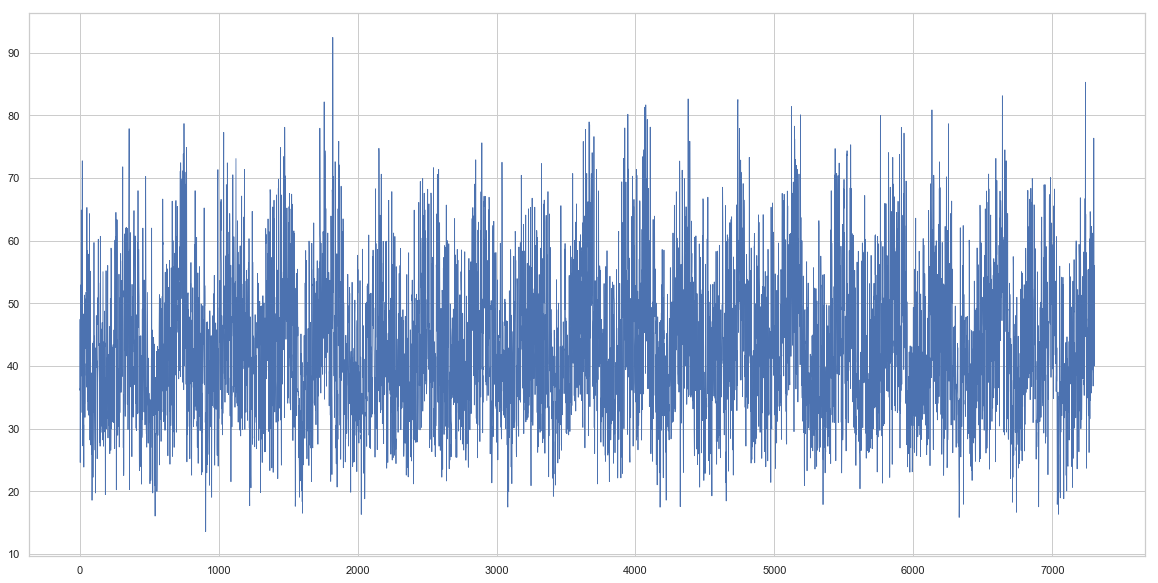

In [20]:
%matplotlib inline
#dir = '/Volumes/Seagate Backup Plus Drive/meteo-badc/ggap/' # 1979-1993 (1995-2003)
#year_list = [(year0+i) for i in range(40)]
year0=1979
year_list = [(year0+i) for i in range(20)]
print('analysis for years', year_list)

total_cir = [np.loadtxt('Circ1_'+str(j)+'.txt') for j in year_list] #- result is [nparray(365,3) , nparray(366,3) , ...]
print(np.shape(total_cir))
print('shape',[np.shape(x) for x in total_cir])
print('concatenate circulation')
total_cir = np.concatenate(total_cir,axis=0)
print('shape of concatenated circ',np.shape(total_cir))

time_len = [np.shape(x) for x in total_cir]
print('time',len(time_len))

#a=range(4)
#b=[1+i for i in range(4)]
#plt.figure()
#plt.plot(a,b)

print('plot')
#print('why?')
#print()
plt.figure(figsize=(20,10)) 
plt.plot(range(len(time_len)),total_cir,linewidth=0.8)

#plt.show();




In [5]:
def plot(timestep,p0,p1,l0, l1,cir,year_n):
    plt.switch_backend('agg')
    cir_min = -1500
    cir_max = 1500
    levels = MaxNLocator(nbins=15).tick_values(cir[:, :].min(), cir[:, :].max())
    # fig, (ax0, ax1) = plt.subplots(nrows=2)
    fig, ax1 = plt.subplots(nrows=1)
    im = plt.imshow(np.transpose(cir[:, :]), extent=(p0 * 10, (p1 - 1) * 10, l1 - 1, l0),
                    interpolation='nearest', cmap=cm.gist_rainbow)
    # ax1.set_xticks(range(len(labels1)), [i for i in labels1])
    # ax = fig.add_subplot(131)
    # mesh = ax1.pcolormesh(data, cmap=cm)
    im.set_clim(cir_min, cir_max)
    fig.colorbar(im, shrink=0.6)
    ax1.set_title('daily wind circulation (' + str(year_n) + '), day %03d ' % (timestep))
    ax1.set_xlabel('pressure height')
    ax1.set_ylabel('latitudes')
    fig.tight_layout()
    print('time step', timestep)
    plt.savefig("_tmp%05d.png" % timestep)

def plot_final(p0,p1,l0,l1,cir,var,color):
    fh = 5  # figheight
    fw = 12.5  # figwidth
    m = 6
    plt.switch_backend('agg')
    fig, ax1 = plt.subplots(nrows=1)
    #adjustFigAspect(fig, aspect=.4)
    fig.set_figheight(fh)
    fig.set_figwidth(fw)
    plt.plot((cir),'o',color,linewidth=1.1)
    ax1.set_title('daily '+str(var)+' for region (p,lat) = (['+str(p0)+','+str(p1)+'],['+str(l0)+','+str(l1)+'])')
    ax1.set_xlabel('year')
    ax1.set_ylabel(''+str(var)+'')
    fig.tight_layout()
    plt.xticks(fontsize=m)
    plt.yticks(fontsize=m)
    ax1.legend(fontsize=m)
    plt.savefig(''+str(var)+'1979-2018.png')

def adjustFigAspect(fig, aspect=1):
    '''
    Adjust the subplot parameters so that the figure has the correct
               aspect ratio.
    '''
    xsize, ysize = fig.get_size_inches()
    minsize = min(xsize, ysize)
    xlim = .4 * minsize / xsize
    ylim = .4 * minsize / ysize
    if aspect < 1:
        ylim *= aspect
    else:
        xlim /= aspect
    fig.subplots_adjust(left=.5 - xlim,
                        right=.5 + xlim,
                        bottom=.5 - ylim,
                        top=.5 + ylim)
#-----------------------------------------------------------------------------------------------------------------------


In [6]:
movie = False
if movie == True:
 timestep = 0
 for d in dates:  # for those files corresponding to a same day, within each year, list all of them

    print('plot figure for time step',timestep)
    fps = 3                                         # nb of frames per second for the movie

    cir_min = -1500
    cir_max = 1500
    movie_figures = True
    if movie_figures == True:

     plt.switch_backend('agg')
     fig = plt.figure()
     levels = MaxNLocator(nbins=15).tick_values(cir[:, :].min(), cir[:, :].max())
     # pick the desired colormap, sensible levels, and define a normalization
     # instance which takes data values and translates those into levels.
     cmap = plt.get_cmap('PiYG')
     norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
     # fig, (ax0, ax1) = plt.subplots(nrows=2)
     fig, ax1 = plt.subplots(nrows=1)
     pa = np.array([i for i in range(p0, p1)])  # array indices of pressure height
     x = np.array([p[prs] for prs in pa])  # pressure at index, in mbar
     y = lat  # latitude in degrees
     im = plt.imshow(cir[:, :], extent=(x.min(), x.max(), y.max(), y.min()),
                    interpolation='nearest', cmap=cm.gist_rainbow)
     fig.colorbar(im, shrink=0.4)



     #fig = plt.figure()
     #ax = fig.add_subplot(131)
     #mesh = ax1.pcolormesh(data, cmap=cm)
     im.set_clim(cir_min, cir_max)

     ax1.set_title('daily wind circulation (1979), day %03d ' %timestep)
     fig.tight_layout()
     print('time step',timestep)

     plt.savefig("_tmp%05d.png" % timestep)

     timestep = timestep +1
     #plt.clf()  # Clear the figure to make way for the next image.

     if timestep == 364:
        os.system("rm -f movie.mp4")
        os.system("./ffmpeg -r " + str(fps) + " -b 1800 -i _tmp%05d.png movie.mp4")
        os.system("rm _tmp*.png")

        exit()

